In [82]:
# Library import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from itertools import combinations
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

# Importing and cleaning the data

In [2]:
# Load Data and keep year from release date

data = pd.read_csv("../data/movie_data_imdbscores.csv")
data.release_date = pd.to_datetime(data.release_date).apply(lambda x: x.year)


# Select features to keep in analysis


# WE DO NOT KEEP RUN TIME AND ACTOR AGE AT MOVIE RELEASE BECAUSE OF HIGH NUMBERS OF NA


to_keep = ['movie_id', 'release_date', 
           #'runtime', 'actor_age_at_movie_release',
       'english language','german language', 'silent film language', 'spanish language',
       'japanese language', 'italian language', 'tamil language',
       'hindi language', 'malayalam language', 'mandarin language',
       'french language', 'Action', 'Adventure', 'Horror', 'Thriller', 'Drama',
       'Crime Fiction', 'Black-and-white', 'Comedy', 'Indie', 'Short Film',
       'Silent film', 'Family Film', 'World cinema', 'Musical',
       'Action/Adventure', 'Romance Film', 'Romantic drama', 'Comedy film',
       'Documentary', 'F_gender_porportion', 'averageRating',
       'numVotes']
data = data[to_keep].set_index('movie_id')

Some characters in column names cause problems, such as whitespace

In [3]:
# Replace problematic characters and typos
data = data.rename(lambda d: d.replace(' ', '_'), axis = 1)
data = data.rename(lambda d: d.replace('-', '_'), axis = 1)
data = data.rename(lambda d: d.replace('/', '_'), axis = 1)
data = data.rename(columns = {"F_gender_porportion":"F_gender_proportion"})

In [4]:
data.head()

,release_date,english_language,german_language,silent_film_language,spanish_language,japanese_language,italian_language,tamil_language,hindi_language,malayalam_language,...,World_cinema,Musical,Action_Adventure,Romance_Film,Romantic_drama,Comedy_film,Documentary,F_gender_proportion,averageRating,numVotes
movie_id,,,,,,,,,,,,,,,,,,,,,
30332673,2010,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,0.666667,3.7,3222
4213160,1971,True,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,0.250000,6.3,2631
20624798,2008,True,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,0.111111,7.2,22
2250713,1988,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,0.000000,5.9,82
25969588,2007,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,0.200000,6.4,346


# Basic plotting and discretization of ratings

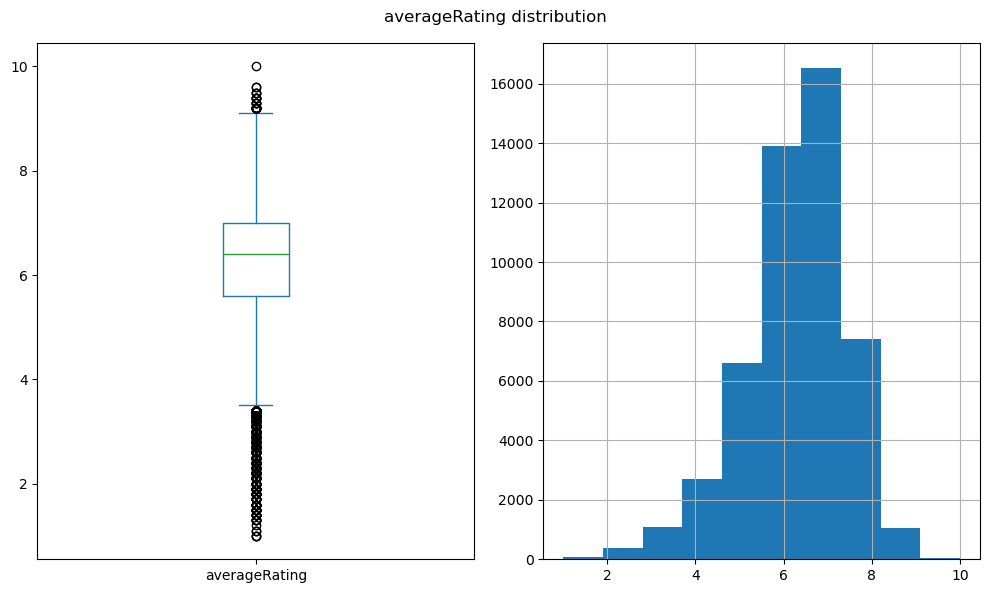

In [5]:
# Plot averageRating distribution

fig, ax = plt.subplots(1, 2, figsize = (10,6))
ax = ax.flatten()
data.averageRating.plot.box(ax = ax[0])
data.averageRating.hist(ax = ax[1])
fig.suptitle("averageRating distribution")
plt.tight_layout()
plt.show()

In [6]:
data.averageRating.describe()

count    49785.000000
mean         6.224752
std          1.146467
min          1.000000
25%          5.600000
50%          6.400000
75%          7.000000
max         10.000000
Name: averageRating, dtype: float64

In [7]:
# Discretize feature based on quantiles
def discretize_column(data, n, label_suffix = "_star"):
    
    # Compute proportion for quantile
    p = 1/(n)
    
    # Return semgments
    return pd.cut(data,
                  # Create interval cuts
                  bins = [np.quantile(data, x * p) if x != n else np.inf
                          for x in range(n+1)],
                  right = False,
                  # assign labels
                  labels = [f"{i+1}{label_suffix}" for i in range(n)])

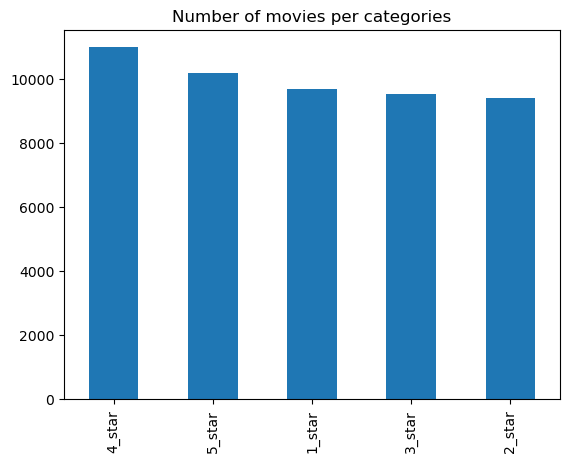

In [8]:
# Perform discretization and save categories in new feature
data["score_discretized"] = discretize_column(data.averageRating, 5)

# Verify Discretization proportions
data.score_discretized.value_counts().plot.bar()
plt.title("Number of movies per categories")
plt.show()

In [9]:
# Compute mean proportions and means for numeric values
grouped = data.groupby('score_discretized')
grouped_means = grouped.mean()
grouped_means

,release_date,english_language,german_language,silent_film_language,spanish_language,japanese_language,italian_language,tamil_language,hindi_language,malayalam_language,...,World_cinema,Musical,Action_Adventure,Romance_Film,Romantic_drama,Comedy_film,Documentary,F_gender_proportion,averageRating,numVotes
score_discretized,,,,,,,,,,,,,,,,,,,,,
1_star,1986.497834,0.631628,0.014442,0.025273,0.023623,0.013720,0.027646,0.024345,0.076026,0.017124,...,0.089849,0.049618,0.112956,0.124097,0.040128,0.038684,0.006293,0.342291,4.456994,2526.612544
2_star,1977.950340,0.653764,0.019779,0.031370,0.028286,0.018928,0.029775,0.015951,0.045725,0.010102,...,0.089217,0.056678,0.091876,0.167695,0.055402,0.044981,0.009251,0.339252,5.724777,4220.002765
3_star,1976.805981,0.635467,0.021091,0.026758,0.034523,0.026967,0.035047,0.014376,0.041763,0.009759,...,0.100630,0.059916,0.085729,0.169780,0.063694,0.038300,0.015110,0.341454,6.304344,6221.281637
4_star,1977.724399,0.572613,0.035714,0.028972,0.045554,0.032799,0.038356,0.017128,0.048925,0.013484,...,0.140671,0.060313,0.072977,0.165270,0.067875,0.033072,0.024690,0.335895,6.842365,9172.384111
5_star,1981.735979,0.510362,0.040369,0.019350,0.042039,0.042137,0.032413,0.032119,0.062764,0.021020,...,0.170808,0.064434,0.055201,0.149298,0.065809,0.031628,0.064728,0.313692,7.629427,30623.601316


In [10]:
# Visualize the best and worst scoring groups

grouped_means.iloc[[0,-1], :]

,release_date,english_language,german_language,silent_film_language,spanish_language,japanese_language,italian_language,tamil_language,hindi_language,malayalam_language,...,World_cinema,Musical,Action_Adventure,Romance_Film,Romantic_drama,Comedy_film,Documentary,F_gender_proportion,averageRating,numVotes
score_discretized,,,,,,,,,,,,,,,,,,,,,
1_star,1986.497834,0.631628,0.014442,0.025273,0.023623,0.013720,0.027646,0.024345,0.076026,0.017124,...,0.089849,0.049618,0.112956,0.124097,0.040128,0.038684,0.006293,0.342291,4.456994,2526.612544
5_star,1981.735979,0.510362,0.040369,0.019350,0.042039,0.042137,0.032413,0.032119,0.062764,0.021020,...,0.170808,0.064434,0.055201,0.149298,0.065809,0.031628,0.064728,0.313692,7.629427,30623.601316


# Statistical analysis
As we focus on the upper extreme of the most successful movies, we split the data into movies with the very highest ratings (5-star) and the rest. We will use a standardised version of the dataset for comparing mean differences between features, whereas the non-standarized version will be used for analysis of a single feature, as it is more interpretable.

In [16]:
def one_vs_all_encode(x, th):
    return np.where(x >= th, '5_star', 'other')

data['rating'] = one_vs_all_encode(data['score_discretized'] == '5_star', 0.5)
stat_data = data.drop(['score_discretized', 'averageRating', 'numVotes', 'rating'], axis = 1).astype(float)
stat_data_std = (stat_data - stat_data.mean(axis = 0)) / stat_data.std(axis = 0)

stat_data = pd.merge(stat_data, data['rating'], left_index=True, right_index=True)
stat_data_std = pd.merge(stat_data_std, data['rating'], left_index=True, right_index=True)

In [17]:
stat_data_std

,release_date,english_language,german_language,silent_film_language,spanish_language,japanese_language,italian_language,tamil_language,hindi_language,malayalam_language,...,Family_Film,World_cinema,Musical,Action_Adventure,Romance_Film,Romantic_drama,Comedy_film,Documentary,F_gender_proportion,rating
movie_id,,,,,,,,,,,,,,,,,,,,,
30332673,1.123896,-1.221510,-0.165673,-0.164389,-0.190982,-0.167393,-0.184154,-0.145922,-0.241378,-0.120795,...,-0.264096,-0.368491,-0.248838,-0.301122,-0.428788,-0.250155,5.093075,-0.158628,1.345540,other
4213160,-0.343035,0.818643,-0.165673,-0.164389,-0.190982,-0.167393,-0.184154,-0.145922,-0.241378,-0.120795,...,-0.264096,-0.368491,-0.248838,3.320850,-0.428788,-0.250155,-0.196341,-0.158628,-0.341267,other
20624798,1.048668,0.818643,-0.165673,-0.164389,-0.190982,-0.167393,-0.184154,-0.145922,-0.241378,-0.120795,...,-0.264096,2.713718,-0.248838,-0.301122,-0.428788,-0.250155,-0.196341,-0.158628,-0.903536,5_star
2250713,0.296396,0.818643,-0.165673,-0.164389,-0.190982,-0.167393,-0.184154,-0.145922,-0.241378,-0.120795,...,-0.264096,-0.368491,-0.248838,-0.301122,-0.428788,-0.250155,-0.196341,-0.158628,-1.353352,other
25969588,1.011055,0.818643,-0.165673,-0.164389,-0.190982,-0.167393,-0.184154,-0.145922,-0.241378,-0.120795,...,-0.264096,-0.368491,-0.248838,-0.301122,-0.428788,-0.250155,-0.196341,-0.158628,-0.543684,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7211363,0.898214,0.818643,-0.165673,-0.164389,-0.190982,-0.167393,-0.184154,-0.145922,-0.241378,-0.120795,...,-0.264096,-0.368491,-0.248838,-0.301122,-0.428788,-0.250155,-0.196341,6.303950,-1.353352,other
2453726,0.409237,-1.221510,-0.165673,-0.164389,-0.190982,-0.167393,-0.184154,-0.145922,-0.241378,-0.120795,...,-0.264096,-0.368491,-0.248838,-0.301122,-0.428788,-0.250155,-0.196341,-0.158628,-1.353352,5_star
2123739,0.710146,-1.221510,-0.165673,-0.164389,-0.190982,-0.167393,-0.184154,-0.145922,-0.241378,-0.120795,...,-0.264096,-0.368491,-0.248838,-0.301122,-0.428788,-0.250155,-0.196341,-0.158628,2.694985,other


## T-tests and p-values
As we are doing multiple comparisons, we need to correct the p-values accordingly. However as we cannot assume the features to be statistically independent, we use Bonferroni correction which is more conservative than Sidak.

In [55]:
# test features over dataframe with significance bonferroni correction
def test_over_variables(n_tests, vars, alpha, t1, t2):
    
    # Sidak correction with k = n_tests
    alpha_c = alpha/n_tests

    # Success flag:
    # At least one significant outcome -> underlying effect
    success = False
    
    #List to append significant results
    successes = []
    
    # Save pvalues
    pvalues = []

    print("_____________________________")
    print(f"{n_tests} t-tests with significance: {alpha_c:0.5f}")

    for var in vars:
        # Test var in both periods of time
        test_result = stats.ttest_ind(t1[var], t2[var])
        
        # If the result is significant...
        if test_result.pvalue < alpha_c:
            # Flag success true and keep result for future display
            success = True
            successes.append((var, test_result.pvalue))
        
        #print(f't-Test for Var: {var} -> p: {test_result[1]}')
        pvalues.append(test_result.pvalue)
    print("_____________________________")


    # Display significant results
    if success:
        print("Manifestation of underlying effect between groups in vars:")
        for var in successes:
            print(f"{var[0]} -> pvalue: {var[1]}")
    features = pd.DataFrame(t1.drop('rating', axis=1).columns)
    result = pd.merge(features,pd.DataFrame(pvalues), left_index=True, right_index=True)
    return result.rename(columns={'0_x':'feature', '0_y':'pvalue'})

In [56]:
# Iterate on all comparison combinations
for (label_1,df_1), (label_2, df_2) in combinations(stat_data_std.groupby('rating'), 2):

    # Drop the separating feature
    vars = df_1.columns.drop(['rating'])

    print(">>>>>>>>>>>>>>>>>>>>>>>>>>")
        
    print(f"{label_1} vs {label_2}")
    # Test over all variables with 0.05 significance
    pvalues = test_over_variables(len(vars), vars, 0.05, df_1, df_2)

>>>>>>>>>>>>>>>>>>>>>>>>>>
5_star vs other
_____________________________
32 t-tests with significance: 0.00156
_____________________________
Manifestation of underlying effect between groups in vars:
release_date -> pvalue: 6.072210226458763e-12
english_language -> pvalue: 7.547776873656211e-93
german_language -> pvalue: 9.346017822113613e-22
silent_film_language -> pvalue: 8.566841257249145e-07
spanish_language -> pvalue: 2.6167121082902624e-05
japanese_language -> pvalue: 4.4829387609378635e-25
tamil_language -> pvalue: 4.423372467175144e-19
hindi_language -> pvalue: 0.00013192395187009969
malayalam_language -> pvalue: 2.8225504042444777e-10
french_language -> pvalue: 1.4095185557080883e-25
Action -> pvalue: 2.51272936032383e-46
Adventure -> pvalue: 2.858784610893893e-20
Horror -> pvalue: 1.580439079088995e-74
Thriller -> pvalue: 1.2240865212322907e-19
Drama -> pvalue: 3.638316134924318e-70
Crime_Fiction -> pvalue: 1.341965433610762e-05
Comedy -> pvalue: 2.803687551527723e-23
Indie -

We find that all of the 32 features are statistically significant, which is unsurprising given their nature. However as this is unhelpful our analysis we sort the features by lowest p-value.

In [79]:
pvalues.sort_values(by='pvalue').head(10)

,feature,pvalue
30,Documentary,2.407493e-191
1,english_language,7.547777e-93
14,Horror,1.580439e-74
24,World_cinema,1.173907e-71
16,Drama,3.638316e-70
12,Action,2.512729e-46
21,Short_Film,2.257205e-39
26,Action_Adventure,2.234246e-30
11,french_language,1.409519e-25
5,japanese_language,4.482939e-25


This already gives us some indication as to which features have a large influence on the rating, however we do not learn anything about the magnitude or the positive/negative nature of the effect. To get this information we evaluate the mean differences on standardized data.

In [67]:
mean_diff_grouped = stat_data_std.groupby('rating')
mean_diff = mean_diff_grouped.mean().iloc[0] - mean_diff_grouped.mean().iloc[1]

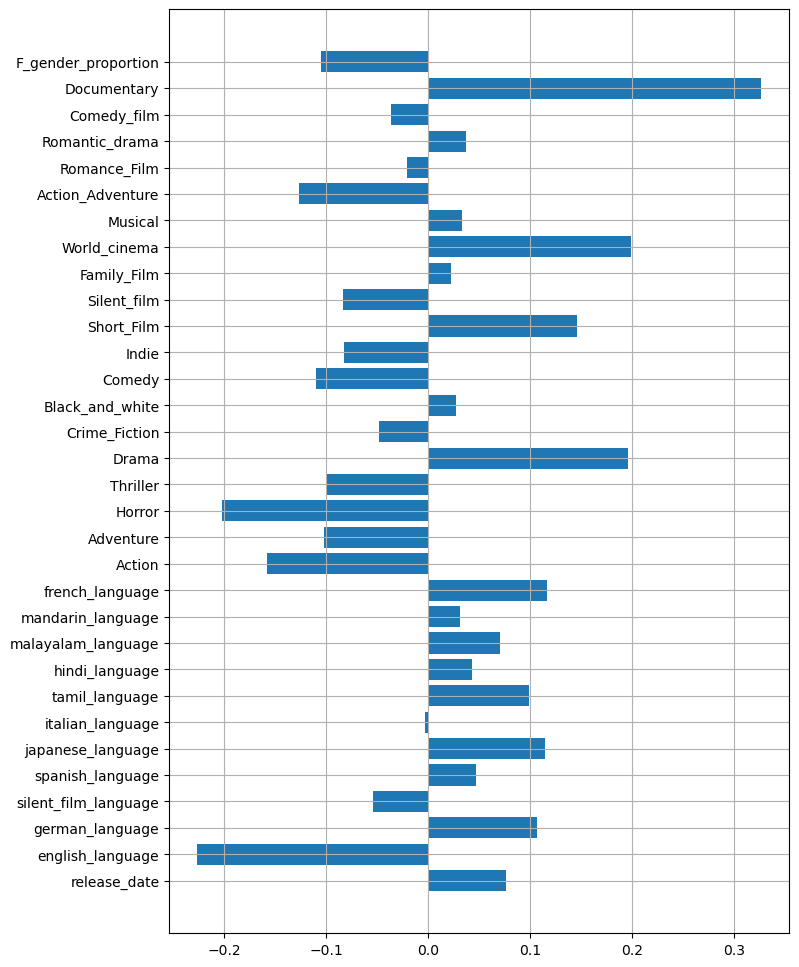

In [68]:
plt.figure(figsize= (8,12))
plt.barh(range(len(mean_diff)), mean_diff)
plt.yticks(range(len(mean_diff)), labels = mean_diff.index)
plt.grid()
plt.show()

### Side tangent: gender bias
It appears that movies with the highest ratings have a non-negligeable gender bias, i.e. the cast includes a lower proportion of women. To confirm this we compare the bootstrapped confidence intervals of the non-standardized gender proportion data for 5-star and non-5-star movies.

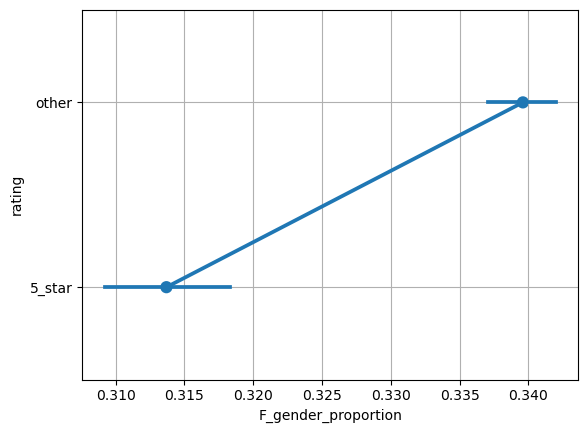

In [119]:
sns.pointplot(data=stat_data, y="rating", x="F_gender_proportion")
plt.grid()

There seems to be indeed a noticeable bias of approximately 3 percentage points in the most critically acclaimed movies.

Let us now find the 5 most helpful and unhelpful features.

In [96]:
mean_diff.sort_values(ascending=False).head(5)

Documentary        0.326442
World_cinema       0.198587
Drama              0.196461
Short_Film         0.145759
french_language    0.116097
dtype: float64

In [97]:
mean_diff.sort_values(ascending=True).head(5)

english_language   -0.226640
Horror             -0.202617
Action             -0.158631
Action_Adventure   -0.127197
Comedy             -0.110392
dtype: float64

### Effect of language
As making the movie in english seems to be the worst choice possible, let us first examine the effect of language with English and French.

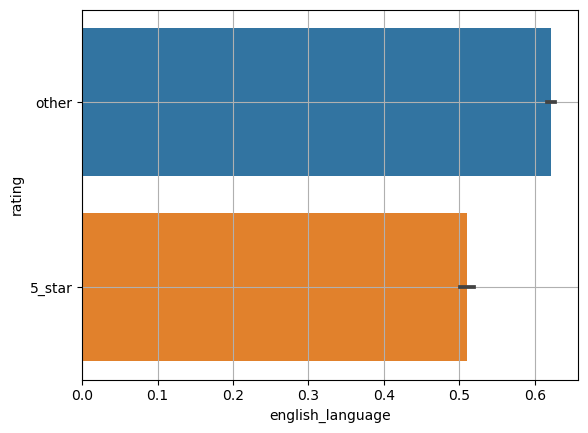

In [111]:
sns.barplot(data=stat_data, y="rating", x="english_language")
plt.grid()

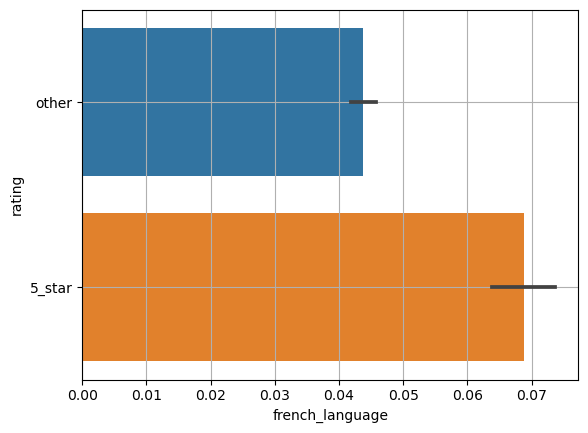

In [110]:
sns.barplot(data=stat_data, y="rating", x="french_language")
plt.grid()

Our results suggest that movies in French instead of English have a much higher likelihood to receive critical acclaim

### Effect of genre
As we wish to make the most IMDB-successful movie possible, we will focus on the 4 most positively correlated genres.

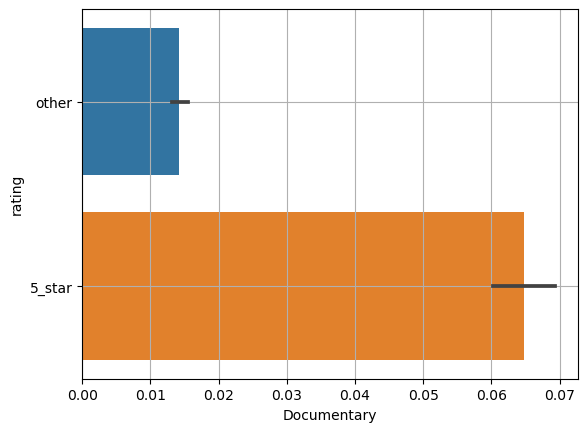

In [112]:
sns.barplot(data=stat_data, y="rating", x="Documentary")
plt.grid()

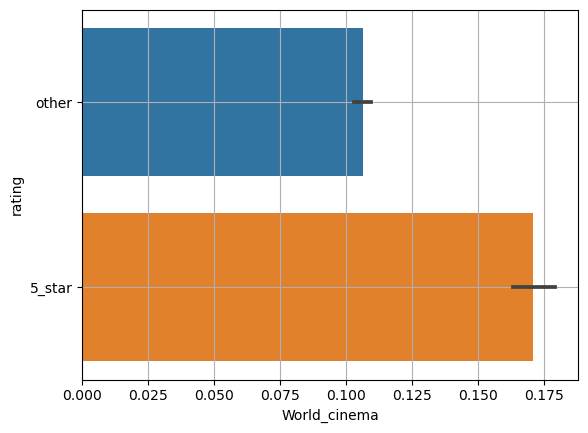

In [113]:
sns.barplot(data=stat_data, y="rating", x="World_cinema")
plt.grid()

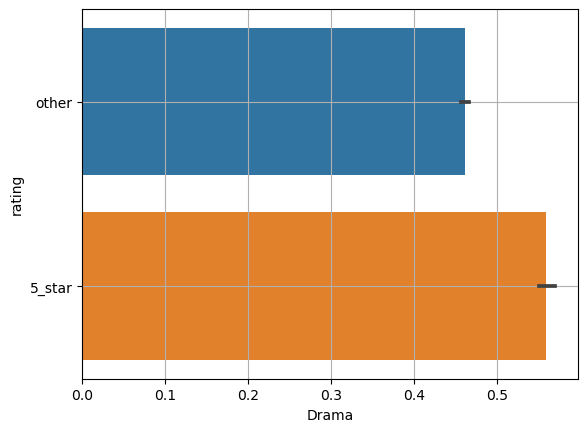

In [116]:
sns.barplot(data=stat_data, y="rating", x="Drama")
plt.grid()

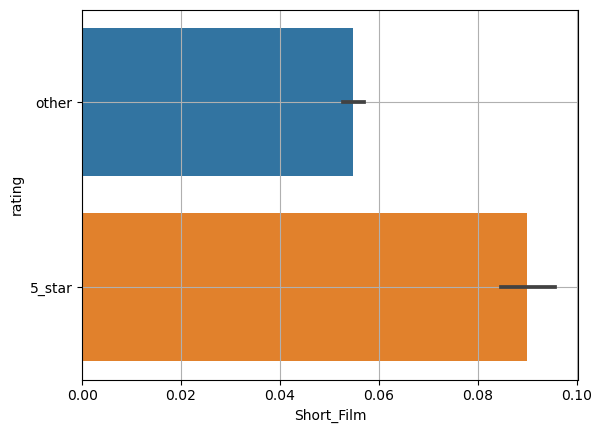

In [118]:
sns.barplot(data=stat_data, y="rating", x="Short_Film")
plt.grid()

As the confidence intervals are very distinct, we conclude that documentaries, world cinema, dramas and short films perform better in the IMDB